Plot Fig. S5

In [19]:
import pandas as pd

In [20]:
evaluation_results1 = pd.read_pickle("../model/data/tables/params/1982-2016/evaluation_results_1600_3200.pkl")
evaluation_results2 = pd.read_pickle("../model/data/tables/params/1982-2016/evaluation_results_0000_1600.pkl")
evaluation_results = evaluation_results1 + evaluation_results2

In [21]:
## Get best metric for each pixel
def best_metric(data):
    models = ['CDD', 'DM', 'SIAM', 'SIAMN', 'SIAMNP']
    rows = []

    for rec in data:
        row = {'latitude': rec['latitude'], 'longitude': rec['longitude']}
        for m in models:
            rmse = rec.get('test_rmse', {}).get(m)
            r2   = rec.get('test_r2',   {}).get(m)
            slope= rec.get('test_slope',{}).get(m)
            row[f'{m}_rmse']  = rmse
            row[f'{m}_r2']    = r2
            row[f'{m}_slope'] = slope
        rows.append(row)
    
    df_evaluation = pd.DataFrame(rows)

    # Lowest RMSE model
    rmse_cols = [f"{m}_rmse" for m in models]
    df_evaluation["lowest_rmse"] = (
        df_evaluation[rmse_cols].idxmin(axis=1).str.replace("_rmse", "", regex=False)
    )

    # Highest R² model
    r2_cols = [f"{m}_r2" for m in models]
    df_evaluation["highest_r2"] = (
        df_evaluation[r2_cols].idxmax(axis=1).str.replace("_r2", "", regex=False)
    )

    # Slope closest to 1
    slope_cols = [f"{m}_slope" for m in models]
    slope_diff = (df_evaluation[slope_cols] - 1).abs()
    df_evaluation["slope_closest_to_1"] = (
        slope_diff.idxmin(axis=1).str.replace("_slope", "", regex=False)
    )

    return df_evaluation


In [22]:
## Show maps
import matplotlib.pyplot as plt
import rasterio as rs
from rasterio.features import rasterize
from rasterio.transform import from_origin
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from shapely.geometry import box
import matplotlib.path as mpath
from matplotlib.colors import ListedColormap


def rasterize_best_model(gdf, transform, width, height, model_classes, metric):
    shapes = (
        (geom, model_classes[model])
        for geom, model in zip(gdf.geometry, gdf[metric])
    )
    model_raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=np.nan,
        dtype="float32",
    )
    return model_raster


def show_best_model_map(
    df, metric,
    tiff_path="../data/satellite_data/images/base-image/test.tif",
    mode="scale_xy",            # "absolute", "scale", or "scale_xy"
    res_x=0.25,                 # used for "absolute": pixel width in CRS units
    res_y=0.25,                 # used for "absolute": pixel height in CRS units
    scale_factor=2.0,           # used for "scale": same factor for both axes
    scale_factor_x=12.5,        # used for "scale_xy": longitude (x) factor
    scale_factor_y=9.4,         # used for "scale_xy": latitude (y) factor
    continents=None             # e.g., ["North America", "Europe"]; None = all land
):
    # Read base raster for CRS and bounds
    with rs.open(tiff_path) as src:
        crs = src.crs
        left, bottom, right, top = src.bounds
        transform0 = src.transform

    orig_res_x = transform0.a
    orig_res_y = abs(transform0.e)

    if mode == "absolute":
        px_x = res_x
        px_y = res_y
    elif mode == "scale":
        px_x = orig_res_x * scale_factor
        px_y = orig_res_y * scale_factor
    elif mode == "scale_xy":
        px_x = orig_res_x * scale_factor_x
        px_y = orig_res_y * scale_factor_y
    else:
        raise ValueError("mode must be 'absolute', 'scale', or 'scale_xy'")

    width = int(np.ceil((right - left) / px_x))
    height = int(np.ceil((top - bottom) / px_y))
    transform = from_origin(left, top, px_x, px_y)

    print(f"[DEBUG] Original pixel size: x={orig_res_x}, y={orig_res_y} (CRS units)")
    print(f"[DEBUG] New pixel size: x={px_x}, y={px_y} (CRS units)")
    print(f"[DEBUG] Output grid: width={width}, height={height}")

    # Fixed model-color mapping
    model_colors = {
        'CDD': '#A3D4E0',         # Brighter Light Blue
        'DM': '#5BAED8',         # Bright Medium Blue
        'SIAM': '#3B83C4',        # Bright Blue
    
        'SIAMN': '#EA9E88',  # Bright Light Red (Coral)
        'SIAMNP': '#D1837D' # Bright Red (Carmine)
    }
    model_classes = {name: i for i, name in enumerate(model_colors.keys())}

    # Build GeoDataFrame with the same CRS as the base raster
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs=crs
    )

    # Filter points to raster bounds
    raster_bounds = box(left, bottom, right, top)
    gdf = gdf[gdf.geometry.within(raster_bounds)]
    print(f"[DEBUG] Points inside raster bounds: {len(gdf)}")

    # Rasterize categorical model classes
    model_raster = rasterize_best_model(gdf, transform, width, height, model_classes, metric)

    # Build a land (continental) mask using Natural Earth via Cartopy
    # 1) Get the Natural Earth 'admin_0_countries' shapefile (WGS84/EPSG:4326)
    ne_path = shpreader.natural_earth(
        resolution="110m",
        category="cultural",
        name="admin_0_countries"
    )
    countries = gpd.read_file(ne_path)  # CRS: EPSG:4326

    # Optional continent filter (field name is 'CONTINENT' in this dataset)
    if continents is not None:
        countries = countries[countries["CONTINENT"].isin(continents)]

    # 2) Dissolve to a single land polygon
    land_poly = countries.union_all()
    land_gdf = gpd.GeoDataFrame(geometry=[land_poly], crs="EPSG:4326")

    # 3) Reproject to the base raster CRS
    land_gdf = land_gdf.to_crs(crs)

    # 4) Clip to raster bounds
    land_gdf = gpd.clip(land_gdf, gpd.GeoDataFrame(geometry=[raster_bounds], crs=crs))

    # 5) Rasterize a binary land mask on the same grid
    land_mask = rasterize(
        [(geom, 1) for geom in land_gdf.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint8",
    )

    # 6) Set pixels outside land to NaN
    model_raster = np.where(land_mask == 1, model_raster, np.nan)

    # Plot
    fig = plt.figure(figsize=[6, 6])
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
    ax.coastlines()

    # Circular mask for polar plot
    theta = np.linspace(0, 2 * np.pi, 100)
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * 0.5 + [0.5, 0.5])
    ax.set_boundary(circle, transform=ax.transAxes)

    cmap = ListedColormap([model_colors[m] for m in model_classes.keys()])
    cmap.set_bad((0, 0, 0, 0))  # Make NaN transparent

    ax.imshow(
        np.ma.masked_invalid(model_raster),
        cmap=cmap,
        extent=[left, right, bottom, top],
        transform=ccrs.PlateCarree(),
        origin="upper",
        interpolation="nearest",
    )

    # Gridlines and labels
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
    gl = ax.gridlines(linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 60))
    gl.ylocator = mticker.FixedLocator([30, 50, 70])
    lat_formatter = LatitudeFormatter()
    lon_formatter = LongitudeFormatter()
    for lat in [30, 50, 70]:
        ax.text(180, lat + 5, lat_formatter(lat),
                transform=ccrs.PlateCarree(), ha='left', va='center',
                fontsize=12, color='black')
    for lon in np.arange(-180, 181, 60):
        if lon == -180 or lon == -60:  # skip -180 (already done) and -60 (60°W)
            continue
    
        label_lon, label_lat = lon, 25  # adjust position
    
        if lon in [-120, 120]:
            label_lat = 23
        if lon == 0:
            label_lon = 2
            label_lat = 29
        if lon == 180:
            label_lon = 178
    
        ax.text(label_lon, label_lat, lon_formatter(lon),
                transform=ccrs.PlateCarree(),
                ha='center', va='top', fontsize=12, color='black')
        
    # ----- Model percentage bar chart inset -----
    valid_pixels = np.isfinite(model_raster).sum()
    percentages = []
    
    for model, idx in model_classes.items():
        count = np.sum(model_raster == idx)
        pct = (count / valid_pixels) * 100 if valid_pixels > 0 else 0
        percentages.append(pct)
    
    # Create inset axes in bottom-right corner (adjust values if needed)
    inset_ax = fig.add_axes([0.12, 0.10, 0.35, 0.25])  # [left, bottom, width, height]
    
    inset_ax.bar(
        model_classes.keys(),
        percentages,
        color=[model_colors[m] for m in model_classes.keys()],
        edgecolor="none"
    )
    
    inset_ax.tick_params(axis="x", labelrotation=45, labelsize=10)
    inset_ax.tick_params(axis="y", labelsize=10)
    inset_ax.set_ylabel("Percentage (%)", fontsize=10)

    # Remove excessive borders inside inset
    inset_ax.spines['top'].set_visible(False)
    inset_ax.spines['right'].set_visible(False)

    # plt.tight_layout()
    # plt.show()
    return fig

In [23]:
df_evaluation = best_metric(evaluation_results)

[DEBUG] Original pixel size: x=0.1, y=0.1 (CRS units)
[DEBUG] New pixel size: x=1.25, y=0.9400000000000001 (CRS units)
[DEBUG] Output grid: width=289, height=58
[DEBUG] Points inside raster bounds: 3241


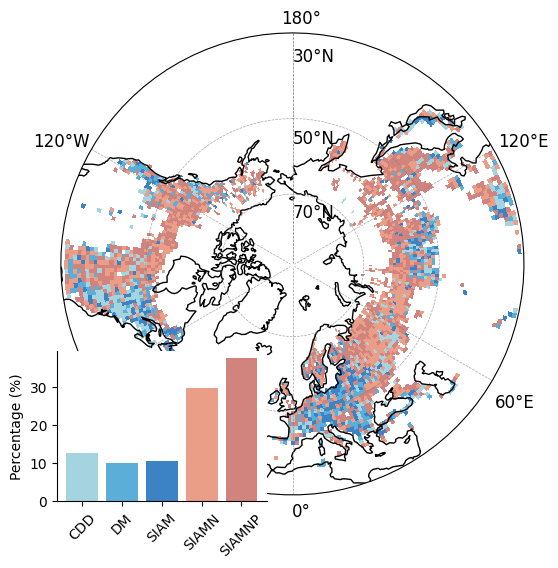

In [24]:
fig = show_best_model_map(df_evaluation, 'lowest_rmse')
fig.savefig("../results/si_figures/si_fig5/lowest_rmse.png", dpi=300, bbox_inches='tight')

[DEBUG] Original pixel size: x=0.1, y=0.1 (CRS units)
[DEBUG] New pixel size: x=1.25, y=0.9400000000000001 (CRS units)
[DEBUG] Output grid: width=289, height=58
[DEBUG] Points inside raster bounds: 3241


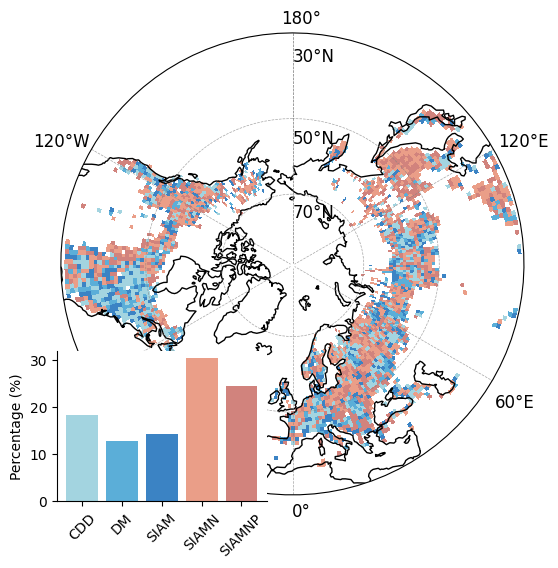

In [25]:
fig = show_best_model_map(df_evaluation, 'highest_r2')
fig.savefig("../results/si_figures/si_fig5/highest_r2.png", dpi=300, bbox_inches='tight')

[DEBUG] Original pixel size: x=0.1, y=0.1 (CRS units)
[DEBUG] New pixel size: x=1.25, y=0.9400000000000001 (CRS units)
[DEBUG] Output grid: width=289, height=58
[DEBUG] Points inside raster bounds: 3241


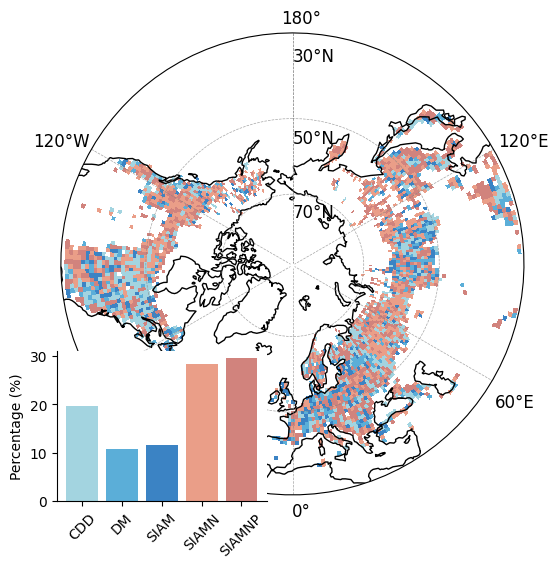

In [26]:
fig = show_best_model_map(df_evaluation, 'slope_closest_to_1')
fig.savefig("../results/si_figures/si_fig5/slope_closest_to_1.png", dpi=300, bbox_inches='tight')